In [9]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

* A DESCR key describing the dataset
* A data key containing an array with one row per instance and one column per
feature
* A target key containing an array with the labels

In [10]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [11]:
y.shape

(70000,)

In [12]:
X.shape[1] == (28 * 28)  # each image is 28*28 pixels

True

(-0.5, 27.5, 27.5, -0.5)

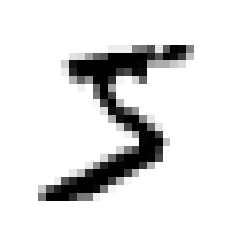

In [13]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)  # back to 28*28 form
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")

In [14]:
y[0]

'5'

In [15]:
import numpy as np
y = y.astype(np.uint8)

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# shuffle the training set => guarantee that all cross-validation folds will be similar
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [17]:
# training a binary classfier by identify one digit (5)
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

# Binary Classifier

In [18]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [19]:
sgd_clf.predict([some_digit])

array([False])

# Performance measure

In [20]:
# Performance measures
# using cross-validation
# but now use something similiar
# StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class.

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)  # create clone of the classifier
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/Users/samuelwong/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.96435
0.9035
0.96425


## cross-validation

In [21]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96435, 0.9035 , 0.96425])

In [22]:
# dumb classifier that predicts all not-5
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [23]:
cross_val_score(Never5Classifier(),
                X_train,
                y_train_5,
                cv=3,
                scoring="accuracy")

array([0.91125, 0.90955, 0.90815])

In [24]:
sum(y == 5) / len(y) * 100

# only about 10% of the images are 5s
# so if predicts all not 5 will correct for 90% of the datasets

9.018571428571429

## confusion matrix

In [25]:
from sklearn.model_selection import cross_val_predict  # returns the predictions made on each test fold.
# This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).
# so that leave test sets untouched

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
# row => actual class
# columns => predicted class

array([[52357,  2222],
       [ 1136,  4285]])

In [27]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [28]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5,
                y_train_pred)  # accuracy of the positive predictions

0.6585215921315506

In [29]:
recall_score(y_train_5,
             y_train_pred)  # sensitivity or true positive rate (TPR)
# this is the ratio of positive instances that are correctly detected by the classifier

0.7904445674229846

In [30]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)  #  harmonic mean of precision and recall

0.7184775318578134

- so if you want to have very high true positive ( high precision ) and accept rejects lossing many actual positive ( row recall )
- else want all possible positive predicted class ( high recall )

In [31]:
y_scores = sgd_clf.decision_function([some_digit])  # thresholds
y_scores

array([-75.34791731])

In [32]:
threshold = 0  # cut off line between positive predictions and negative
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [33]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
# raising thresholds will reduce recall

array([False])

## precision_recall_curve & precision vs recall

In [34]:
# to decide which thresholds to use
y_scores = cross_val_predict(sgd_clf,
                             X_train,
                             y_train_5,
                             cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
# tradeoff between precision and recall

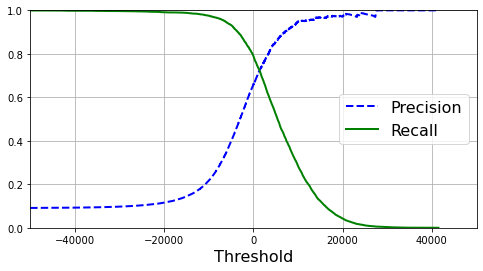

In [35]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds,
             precisions[:-1],
             "b--",
             label="Precision",
             linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)  # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)  # Not shown
    plt.grid(True)  # Not shown
    plt.axis([-50000, 50000, 0, 1])  # Not shown


plt.figure(figsize=(8, 4))  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# notes :
# precision may sometimes go down when you raise the threshold (although in general it will go up).
# recall can only go down when the thres‐ hold is increased, which explains why its curve looks smooth.

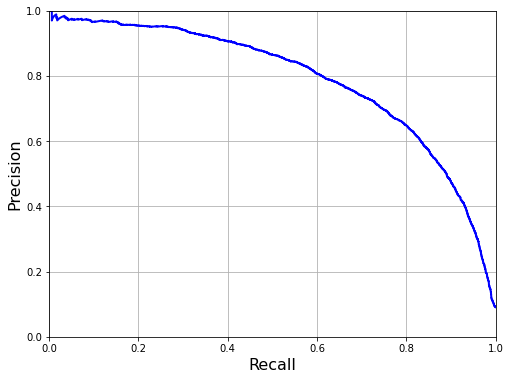

In [36]:
# precision against recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)


plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

In [37]:
# want 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [38]:
threshold_90_precision

7005.610051713279

In [39]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [40]:
precision_score(y_train_5, y_train_pred_90)

0.9001980198019802

In [41]:
recall_score(y_train_5, y_train_pred_90)

0.4192953329643977

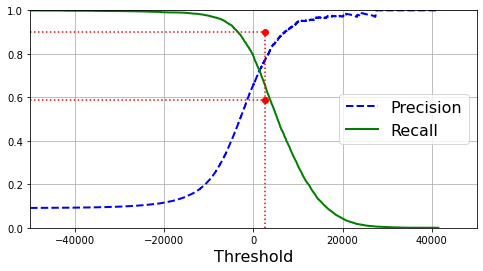

In [42]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds,
             precisions[:-1],
             "b--",
             label="Precision",
             linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)  # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)  # Not shown
    plt.grid(True)  # Not shown
    plt.axis([-50000, 50000, 0, 1])  # Not shown


plt.figure(figsize=(8, 4))  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([2563, 2563], [0., 0.9], "r:")  # plot the vertical point
plt.plot([-50000, 2563], [0.9, 0.9], "r:")  # plot precision horizontal line
plt.plot([-50000, 2563], [0.5899, 0.5899], "r:")  # plot recall horizontal line
plt.plot([2563], [0.9], "ro")  # plot precision vertical line
plt.plot([2563], [0.5899], "ro")  # plot recall vertical line

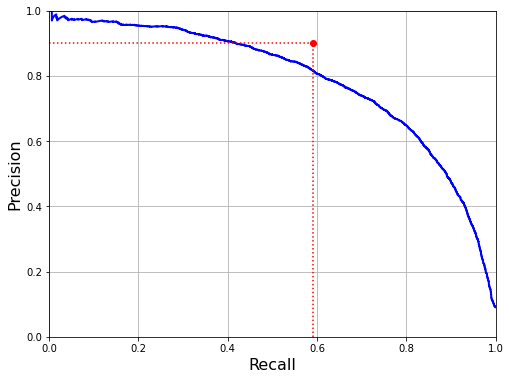

In [43]:
# precision against recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)


plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.5899], [0.9], 'ro')
plt.plot([0.5899, 0.5899], [0, 0.9], 'r:')
plt.plot([0, 0.5899], [0.9, 0.9], 'r:')

## ROC Curve

In [44]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

<function matplotlib.pyplot.show(*args, **kw)>

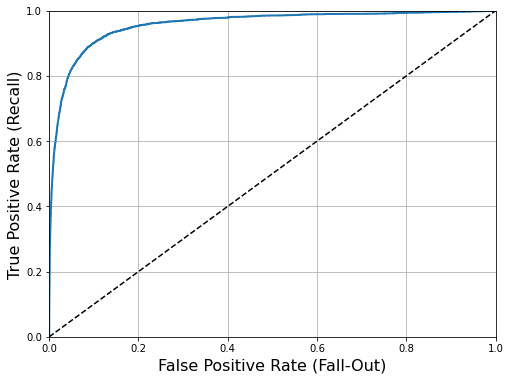

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # dashed diagonal
    plt.axis([0, 1, 0, 1])  # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)  # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)  # Not shown
    plt.grid(True)  # Not shown


plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show

# tradeoff with recall(TPR) and FPR

In [46]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_train_5, y_scores))

# notes
'''
AUC = area under curve, perfect classifier have auc == 1 while random == 0.5
ROC curve or PR curve
prefer PR when positive class is rare or care more on false positives than false negative
'''

0.9575201886024255


'\nAUC = area under curve, perfect classifier have auc == 1 while random == 0.5\nROC curve or PR curve\nprefer PR when positive class is rare or care more on false positives than false negative\n'

In [47]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3,
    method="predict_proba")  # RF din have decision function but predict proba

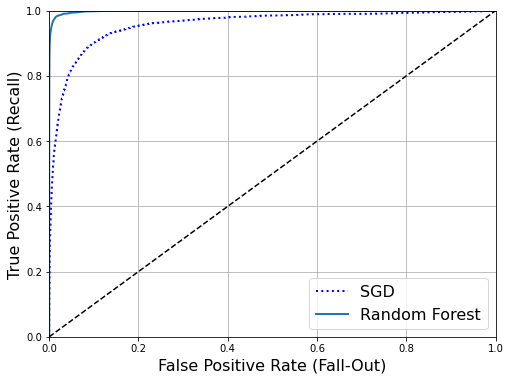

In [48]:
y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,
                                                      y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
'''plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")'''
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [49]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984483955145056

# Multiclass classification

- binary classifiers distinguish 2 class (0,1)
- multiclass classifiers / multinomial classifiers > 2 class

- to use binary classifiers for multiclass classifiers :
1. train a binary classifiers for each class ( one-versus-all )
2. train a binary classifier for every pair of digits ( one-versus-one )

In [51]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [52]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

# Under the hood, Scikit-Learn actually trained 10 binary classifiers, 
# got their decision scores for the image, and selected the class with the highest score.

array([[-17229.36720053, -27703.68107006,  -9268.10113247,
          1221.19345802, -16378.46180068,   4675.78346427,
        -23173.82526037, -11398.88749803,  -7333.06667957,
         -8900.31722582]])

In [57]:
np.argmax(some_digit_scores) # return max value's indices

5

In [54]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [56]:
sgd_clf.classes_[5]

5

In [58]:
# creates a multi‐ class classifier using the OvO strategy, based on a SGDClassifier
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=1000, tol=1e-3, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [60]:
len(ovo_clf.estimators_) # number of estimators == (10 * 9) / 2 == 45

45

In [59]:
forest_clf.fit(X_train, y_train) 
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [61]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.12, 0.01, 0.82, 0.  , 0.01, 0.03, 0.  ]])

In [ ]:
# evaluate the classifiers using cross-validation
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
# output : array([0.8489802 , 0.87129356, 0.86988048])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    
plt.matshow(conf_mx, cmap=plt.cm.gray)